In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
dfTrain = pd.read_csv('../data/TRAIN_TEST_corrected2/train_corrected2.csv').sample(frac=0.05)
train = dfTrain.drop(columns=['price_usd', 'id'], axis=1)
target = dfTrain.price_usd

In [3]:
train.head(3)

,year_created,month_created,day_created,distance_to_obelisco_mtrs,lat,lon,surface_total_in_m2,rooms,PH,apartment,house,store
338349,2013.0,12.0,2.0,10982.297333,-34.537827,-58.470871,43.0,2.0,0.0,1.0,0.0,0.0
524133,2014.0,8.0,7.0,18116.564514,-34.512876,-58.545596,300.0,2.0,0.0,0.0,1.0,0.0
556785,2014.0,8.0,19.0,8909.007943,-34.619177,-58.476894,36.0,1.0,0.0,1.0,0.0,0.0


In [4]:
# PARAMETROS PARA KNN
# Aca estoy definiendo 2 grillas
# (esto me sirve para hacer una que incluya distancia hamming con ball-tree y las demas con kd-tree)
param_grid = [
                {'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 75],
                 'weights': ['uniform', 'distance'],
                 'metric': ['euclidean', 'manhattan', 'chebyshev']}]

# MEDIDA DE SCORE PARA CROSS-VALIDATION
scoring = {'MSE': 'neg_mean_squared_error'}

knn = KNeighborsRegressor(n_jobs=-1)
gs = GridSearchCV(knn, scoring=scoring, param_grid=param_grid, cv=10, refit='MSE', return_train_score=False)

In [5]:
# COMIENZO EL GRID SEARCH
gs.fit(train, target);

In [6]:
results = gs.cv_results_
dfResults = pd.DataFrame(results).loc[:, ('rank_test_MSE', 'mean_test_MSE', 
                                          'param_metric', 'param_n_neighbors', 'param_weights')].infer_objects()

In [7]:
dfResults.sort_values(by='rank_test_MSE').head(10)

,rank_test_MSE,mean_test_MSE,param_metric,param_n_neighbors,param_weights
27,1,-5.973840e+10,manhattan,25,distance
29,2,-5.974955e+10,manhattan,30,distance
25,3,-5.982834e+10,manhattan,20,distance
31,4,-5.986949e+10,manhattan,40,distance
33,5,-6.018629e+10,manhattan,50,distance
11,6,-6.025118e+10,euclidean,30,distance
13,7,-6.033429e+10,euclidean,40,distance
23,8,-6.037611e+10,manhattan,15,distance
9,9,-6.044603e+10,euclidean,25,distance
15,10,-6.046495e+10,euclidean,50,distance


In [8]:
combinatorias = set()

for metric in param_grid[0]['metric'] :
    for weight in param_grid[0]['weights'] :
        tupla = (metric, weight)
        
        if tupla not in combinatorias and tupla[::-1] not in combinatorias :
            combinatorias.add(tupla)
            
dfs = []

for opcion in combinatorias :
    dfs.append(dfResults.loc[dfResults.param_metric.str.contains(opcion[0]) & dfResults.param_weights.str.contains(opcion[1])])

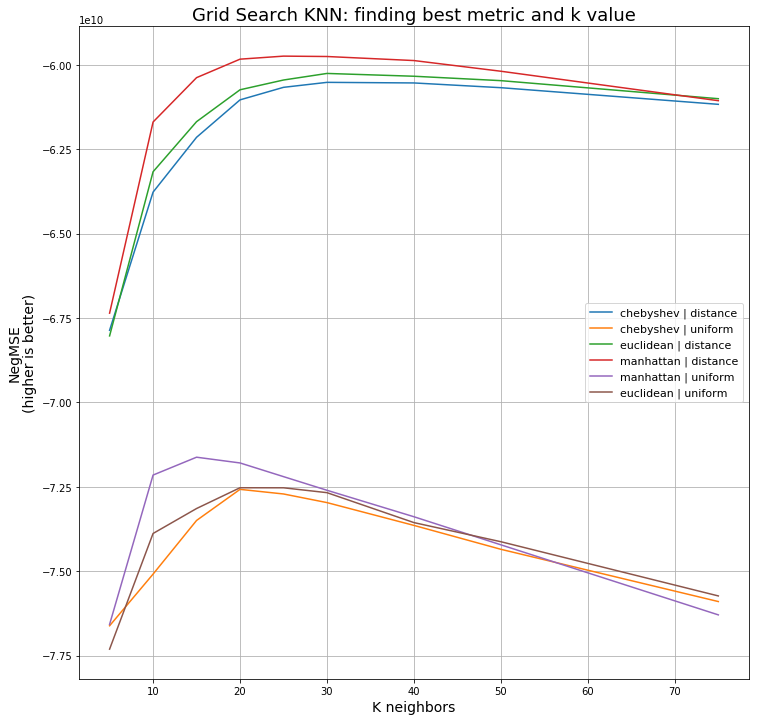

In [33]:
# Ploteo los resultados

ax = None
for df in dfs :
    df = df.reset_index()
    new_name = df.param_metric[0] + ' | ' + df.param_weights[0]
    df = df.rename(columns={'mean_test_MSE':new_name })
    ax = df.plot(ax=ax, x='param_n_neighbors', y=new_name, 
                 figsize=(12, 12))

ax.grid()
ax.set_title("Grid Search KNN: finding best metric and k value", fontsize=18)
ax.set_xlabel('K neighbors', fontsize=14)
ax.set_ylabel('NegMSE\n(higher is better)', fontsize=14)
ax.legend(fontsize=11);

In [28]:
print "\nMejores parametros:", gs.best_params_
print "Tuvieron un error de:", repr(-gs.best_score_), "midiendo como MSE"


Mejores parametros: {'n_neighbors': 25, 'metric': 'manhattan', 'weights': 'distance'}
Tuvieron un error de: 59738400159.669014 midiendo como MSE
